In [12]:
import os
import random
import librosa
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, Wav2Vec2Model

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '/workspace/ssd/AI_hub/speech_recognition/dataset/test.txt'

dataset_name = 'VoiceDatasetWav2Vec'
model_name = 'facebook/wav2vec2-base-960h'
save_model_path = './finetuned_model/wav2vecModel_wav2vec2-base-960h/best_model.pth'
num_workers = 8
seed_number = 42
batch_size = 16

how_many_compare = 15
how_many_each_person_data = 15

In [95]:
class VoiceDatasetWav2Vec(Dataset):
    def __init__(self, data_path, max_length, model_name):
        self.data_path = data_path
        self.max_length = max_length
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.data = []            # 전체 데이터
        self.speaker_files = []   # 총 화자
        self.speaker_datas = {}   # 각 화자에 대한 데이터
        self.labels = []
        
        with open(self.data_path, 'r') as f:
            for line in f:
                self.speaker_files.append(line.strip())
        self.speaker_files = self.speaker_files[:how_many_compare]  ## for sample data test
                
        for txt_file in self.speaker_files:
            speaker_id = os.path.basename(txt_file).split('.')[0]
            with open(txt_file, 'r') as f:
                # self.speaker_datas[speaker_id] = [line.strip() for line in f]
                self.speaker_datas[speaker_id] = [line.strip() for idx, line in enumerate(f) if idx<how_many_each_person_data]
        
        for speaker_id, files in self.speaker_datas.items():
            for file in files:
                self.data.append(file)
                self.labels.append(speaker_id)

    def load_audio(self, file_path):
        audio, sampling_rate = librosa.load(file_path, sr=16000)
        inputs = self.feature_extractor(audio, sampling_rate=sampling_rate, max_length=int(self.max_length * sampling_rate), truncation=True, padding="max_length", return_tensors="pt")
        return inputs.input_values.squeeze(0)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        anchor_data = self.data[idx]
        anchor_audio = self.load_audio(anchor_data)
        label = self.labels[idx]
        
        return anchor_audio, label

In [96]:
test_dataset = VoiceDatasetWav2Vec(data_path, 4.0, model_name)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [97]:
model = Wav2Vec2Model.from_pretrained(model_name).to(device)
model.load_state_dict(torch.load(save_model_path))

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [98]:
model.eval()
embeddings = []
labels = []

test_progress_bar = tqdm(test_dataloader)
for idx, batch in enumerate(test_dataloader):
    anchors, label = batch
    anchors = anchors.to(device)
    with torch.no_grad():
        embedding = model(anchors).last_hidden_state.mean(dim=1)
    embeddings.append(embedding.cpu().numpy())
    labels.extend(label)  # 라벨 리스트를 기존 라벨 리스트에 병합


  0%|          | 0/19 [02:36<?, ?it/s]


In [99]:
embeddings = np.vstack(embeddings)  # 리스트의 2차원 배열을 하나의 큰 행렬로 변환
labels = np.array(labels)  # 리스트를 NumPy 배열로 변환

In [100]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

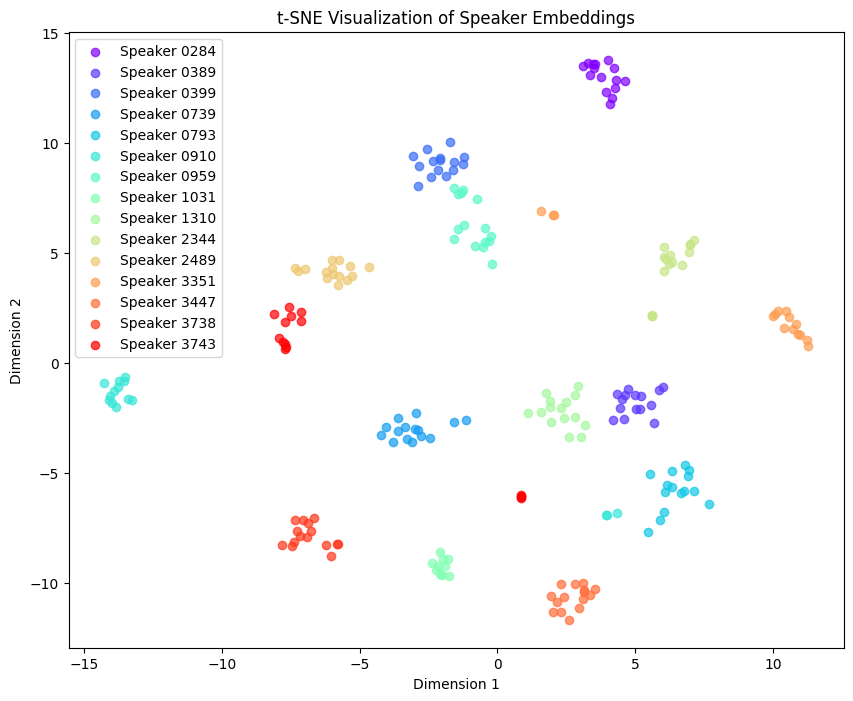

In [101]:
# 시각화
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], color=colors[i], label=f"Speaker {label}", alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of Speaker Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [102]:
# t-SNE를 사용하여 임베딩을 3차원으로 축소
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)


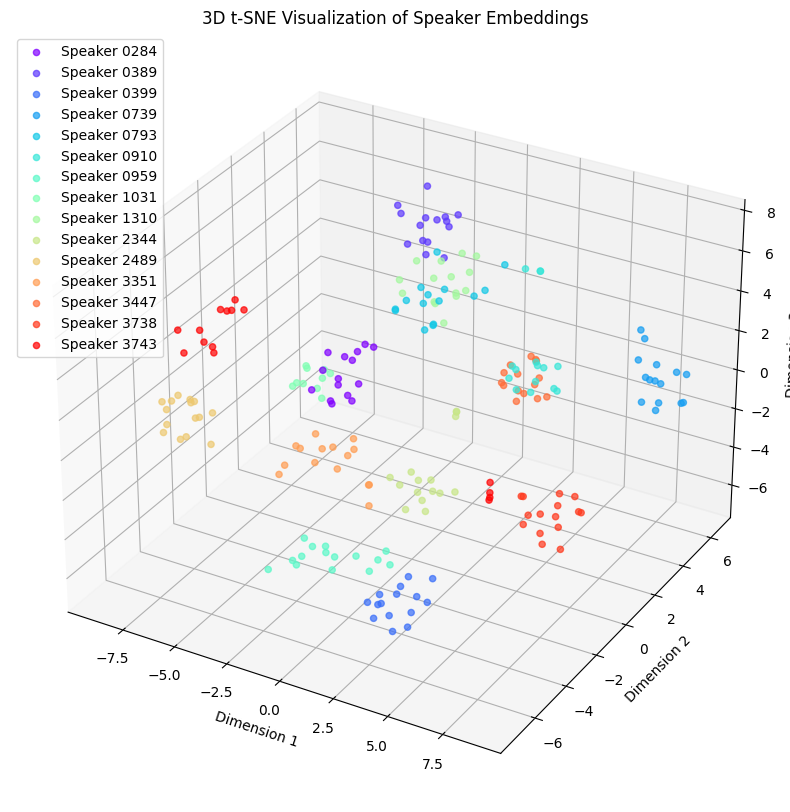

In [103]:

# 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    idx = labels == label
    ax.scatter(embeddings_3d[idx, 0], embeddings_3d[idx, 1], embeddings_3d[idx, 2], color=colors[i], label=f"Speaker {label}", alpha=0.7)

ax.set_title("3D t-SNE Visualization of Speaker Embeddings")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.legend()
plt.show()